# ***Digit Recognizer*** - Image Classification using Deep Learning

I took help from [this notebook](https://www.kaggle.com/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99) in which concepts are explained flawlessly and efficiently!!

## Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import warnings
warnings.filterwarnings(action="ignore")
from sklearn.metrics import confusion_matrix

In [ ]:
my_transform = transforms.Compose([transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST('data', train=True, download=True, transform = my_transform)
mnist_test = torchvision.datasets.MNIST('data', train=False, download=True, transform = my_transform)

# Visualize data

In [ ]:
sample = torchvision.datasets.MNIST('data', train=True, download=True)

plt.figure(figsize = (16, 3))
for i,(image, label) in enumerate(sample):
    if i>=16:
        break
    plt.subplot(2,8,i+1)
    plt.imshow(image)

## Creating Class for RNN Implementation

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.batch_size  = batch_size
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        #rnn layer
        self.rnn = nn.RNN(input_size, hidden_size)
        
        #fully connected layer
        self.layer = nn.Linear(hidden_size, self.output_size)
        
    def forward(self, images, prints=False):
        if prints: print("Original Shape of Image:", images.shape)
        
        images = images.permute(1,0,2)
        if prints: print("Permuted Image Shape:", images.shape)
        
        # initialize hidden state with zeros
        hidden_state = torch.zeros(1, self.batch_size, self.hidden_size)
        if prints: print("Hidden Layer shape:", hidden_state.shape)
            
        hidden_outputs, hidden_state = self.rnn(images, hidden_state)
        
        out = self.layer(hidden_state)
        
        if prints:
            print("\n"+ '----hidden_outputs shape:', hidden_outputs.shape, '\n' +
                  '----final hidden state:', hidden_state.shape, '\n' +
                  '----out shape:', out.shape)
        
        # Reshaped out
        out = out.view(-1, self.output_size)
        if prints: print('Out Final Shape:', out.shape)
        
        return out

In [ ]:
# ==== STATICS ====
batch_size = 64        # how many images to be trained in one iteration
input_size = 28        # image 28 by 28
hidden_size = 150      # can be changed to any number: neurons
output_size = 10       # 10 different digits
# =================

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)

image_example , label_example = next(iter(train_loader))

print("Original Image shape:",image_example.shape)
image_example = image_example.view(-1,28,28)

print("Changed image shape:", image_example.shape)
print("Label shape:", label_example.shape)

model_example = VanillaRNN(batch_size, input_size, hidden_size, output_size)
print("VanillaRNN Model:\n",model_example,"\n")

out = model_example(image_example, prints=True)

## Accuracy Function...🎯

In [ ]:
def accuracy(out, actual_labels, batchSize):
    predictions = out.max(dim=1)[1]
    
    correct = (predictions==actual_labels).sum().item()
    accuracy = correct/batch_size
    
    return accuracy

## Training Function...🚴

In [ ]:
def train_network(model, train_data, test_data, batch_size=64,num_epochs=1, learning_rate=0.001):
    print('Get data ready...')
    # Create dataloader for training dataset - so we can train on multiple batches
    # Shuffle after every epoch
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    
    print('Training started...')
    # Train the data multiple times
    for epoch in range(num_epochs):
        
        # Save Train and Test Loss
        train_loss = 0
        train_acc = 0
        
        # Set model in training mode:
        model.train()
        
        for k, (images, labels) in enumerate(train_loader):
            
            # Get rid of the channel
            images = images.view(-1, 28, 28)
            
            # Create log probabilities
            out = model(images)
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels)
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save Loss & Accuracy after each iteration
            train_loss += loss.item()
            train_acc += accuracy(out, labels, batch_size)
            
        
        # Print Average Train Loss & Accuracy after each epoch
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f} | Accuracy: {:.2f}'.format(epoch+1, num_epochs, train_loss/k, train_acc/k))
            
            
    print('Testing Started...')
    # Save Test Accuracy
    test_acc = 0
    # Evaluation mode
    model.eval()
    
    for k, (images, labels) in enumerate(test_loader):
        # Get rid of the channel
        images = images.view(-1, 28, 28)
        
        # Create logit predictions
        out = model(images)
        # Add Accuracy of this batch
        test_acc += accuracy(out, labels, batch_size)
        
    # Print Final Test Accuracy
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc/k) )

## Training Model..

In [ ]:
batch_size=64
input_size=28
hidden_state=150
output_size=10

model_rnn = VanillaRNN(batch_size, input_size, hidden_size, output_size)

train_network(model_rnn, mnist_train, mnist_test, num_epochs=10)

## **LSTMs** (Long Short Term Memory RNNs)

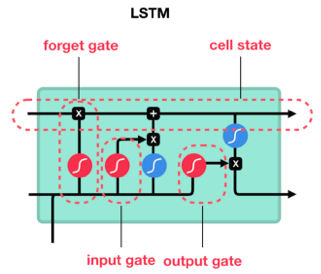

* Note- Checkout [This blog](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) which contains detailed explanation for better understanding of intiution behind long short term memory RNNs and GRUs.


In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size,hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM_Model,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        
        #Initialize LSTM model
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # bidirectional
        if bidirectional:
            self.layer = nn.Linear(hidden_size*2,output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
        
        # FNN
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Set initial states
        if self.bidirectional:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
        else:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
        if prints: print('hidden_state t0 shape:', hidden_state.shape, '\n' +
                         'cell_state t0 shape:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images, (hidden_state, cell_state))
        if prints: print('LSTM: output shape:', output.shape, '\n' +
                         'LSTM: last_hidden_state shape:', last_hidden_state.shape, '\n' +
                         'LSTM: last_cell_state shape:', last_cell_state.shape)
        # Reshape
        output = output[:, -1, :]
        if prints: print('output reshape:', output.shape)
        
        # FNN:
        output = self.layer(output)
        if prints: print('FNN: Final output shape:', output.shape)
        
        return output

In [ ]:
# parameters
batch_size  = 64
input_size  = 28
hidden_size = 100
layer_size  = 2
output_size = 10

In [ ]:
images, labels = next(iter(train_loader))

print("Original Shape of image:", images.shape)

# Remove channel from shape
images = images.view(-1,28,28)
print("Reshaped images shape:", images.shape)

lstm_model = LSTM_Model(input_size, hidden_size, layer_size, output_size)
print("LSTM Model:\n")
print(lstm_model,"\n")

out = lstm_model(images, prints=True)

In [ ]:
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Instantiate the model
# We'll use TANH as our activation function
lstm_model = LSTM_Model(input_size, hidden_size, layer_size, output_size)

# ==== TRAIN ====
train_network(lstm_model, mnist_train, mnist_test, num_epochs=10)

# Confusion Matrix

In [ ]:
def show_confusion_matrix(model, test_data):
    torch.no_grad()    # disable gradient computing
    
    model.eval()
    pred, real = [],[]
    
    for image, label in test_data:
        image = image.view(-1,28,28)
        out = model(image)
        
        prediction = torch.max(out,dim=1)[1].item()
        pred.append(prediction)
        
        real.append(label)
        
    return confusion_matrix(pred, real)

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(show_confusion_matrix(lstm_model,mnist_test),annot=True, cmap="icefire", fmt = ',')
plt.title("Confusion Matrix")

<div class="alert alert_box alert-warning">
UPVOTE the notebook if you find it insightful!
    
See you later:)
</div>